<a href="https://colab.research.google.com/github/mystlee/2024_CSU_AI/blob/main/chapter8/example_speech_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install speechbrain torchaudio huggingface_hub matplotlib -qq

In [6]:
import torch
from speechbrain.pretrained import SepformerSeparation as separator
import torchaudio
from google.colab import files
from IPython.display import Audio
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

In [15]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    sample_file_path = filename

Saving noisy_sample.wav to noisy_sample.wav


In [16]:
model = separator.from_hparams(source = "speechbrain/sepformer-wham16k-enhancement",
                               savedir = "pretrained_models/sepformer-wham16k-enhancement")
est_sources = model.separate_file(path = sample_file_path)

enhanced_file = "enhanced_wham16k.wav"
torchaudio.save("enhanced_wham16k.wav", est_sources[:, :, 0].detach().cpu(), 16000)

In [17]:
print("Sample data")
display(Audio(sample_file_path))
print("\nEnhanced sample")
display(Audio(enhanced_file))

Sample data



Enhanced sample


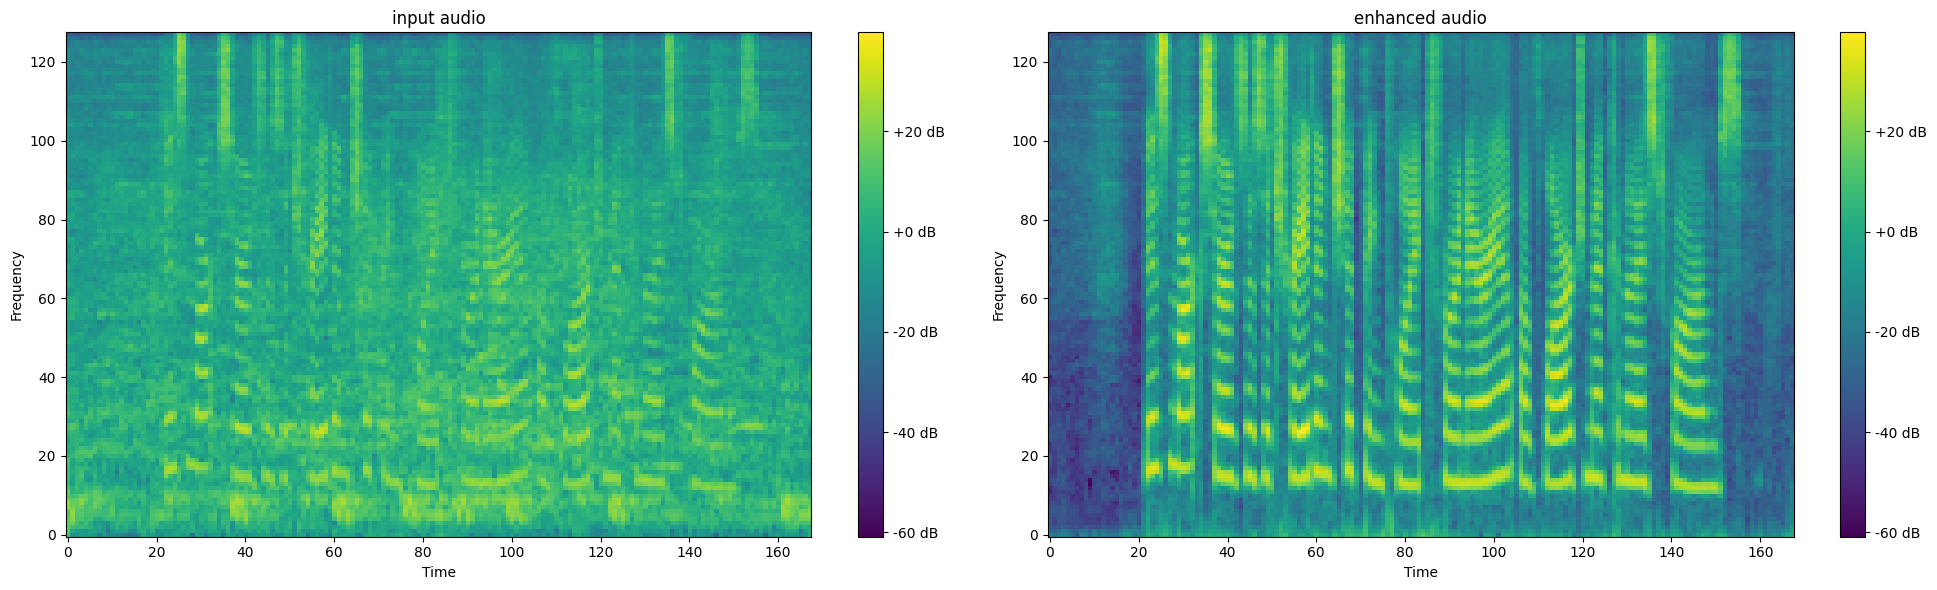

In [18]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate = 16000,
        n_fft = 1024,
        hop_length = 512,
        n_mels = 128)

signal_orig, sr_orig = torchaudio.load(sample_file_path)
if signal_orig.shape[0] > 1:
    signal_orig = torch.mean(signal_orig, dim = 0, keepdim = True)

signal_enhanced, sr_enhanced = torchaudio.load(enhanced_file)
if signal_enhanced.shape[0] > 1:
    signal_enhanced = torch.mean(signal_enhanced, dim = 0, keepdim = True)

mel_orig = mel_spectrogram_transform(signal_orig)
mel_enhanced = mel_spectrogram_transform(signal_enhanced)

mel_orig_db = torchaudio.transforms.AmplitudeToDB()(mel_orig)
mel_enhanced_db = torchaudio.transforms.AmplitudeToDB()(mel_enhanced)

mel_orig_db_np = mel_orig_db.squeeze().numpy()
mel_enhanced_db_np = mel_enhanced_db.squeeze().numpy()

global_min = min(mel_orig_db.min().item(), mel_enhanced_db.min().item())
global_max = max(mel_orig_db.max().item(), mel_enhanced_db.max().item())

fig, axs = plt.subplots(1, 2, figsize = (20, 6))

img1 = axs[0].imshow(mel_orig_db_np, aspect = 'auto',
                     origin = 'lower', cmap = 'viridis',
                     vmin = global_min, vmax = global_max)
axs[0].set_title('input audio')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')
fig.colorbar(img1, ax = axs[0], format = "%+2.f dB")

img2 = axs[1].imshow(mel_enhanced_db_np, aspect = 'auto',
                     origin = 'lower', cmap = 'viridis',
                     vmin = global_min, vmax = global_max)
axs[1].set_title('enhanced audio')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')
fig.colorbar(img2, ax = axs[1], format = "%+2.f dB")

plt.tight_layout()
plt.show()